Imports

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

Read data from ```csv``` files

In [2]:
df1 = pd.read_csv('checkout_1.csv')
df2 = pd.read_csv('checkout_2.csv')

Convert time format

In [3]:
df1['time'] = pd.to_datetime(df1['time'], format='%Hh').dt.strftime('%H:%M')
df1.head()

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month
0,00:00,9,12,11,6.42,4.85
1,01:00,3,5,1,1.85,1.92
2,02:00,1,0,0,0.28,0.82
3,03:00,1,0,0,0.42,0.46
4,04:00,0,0,1,0.42,0.21


In [4]:
df2['time'] = pd.to_datetime(df2['time'], format='%Hh').dt.strftime('%H:%M')
df2.head()

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month
0,00:00,6,9,5,5.00,4.92
1,01:00,3,3,2,2.00,1.92
2,02:00,3,1,2,0.42,0.75
3,03:00,0,1,1,0.42,0.46
4,04:00,0,0,0,0.14,0.21


Connect to ```checkout_data.db``` via SQLite3

In [5]:
conn = sqlite3.connect('checkout_data.db')
cursor = conn.cursor()

Create ```checkout_1``` and ```checkout_2``` tables

In [6]:
cursor.execute('''
    CREATE TABLE IF NOT EXISTS checkout_1 (
        time TEXT,
        today INTEGER,
        yesterday INTEGER,
        same_day_last_week INTEGER,
        avg_last_week REAL,
        avg_last_month REAL
    );
''')
cursor.execute('''
    CREATE TABLE IF NOT EXISTS checkout_2 (
        time TEXT,
        today INTEGER,
        yesterday INTEGER,
        same_day_last_week INTEGER,
        avg_last_week REAL,
        avg_last_month REAL
    )
''')
conn.commit()

Load data on created tables

In [7]:
df1.to_sql('checkout_1', conn, if_exists='replace', index=False)
df2.to_sql('checkout_2', conn, if_exists='replace', index=False)


24

Make a ```SQL Query``` joining checkout tables

In [8]:
query = '''
    SELECT
      c1.time,
      c2.today,
      c2.yesterday,
      c1.yesterday AS '2d_ago',
      c2.same_day_last_week AS '7d_ago',
      c1.same_day_last_week AS '8d_ago'
    FROM
      checkout_1 c1
    JOIN checkout_2 c2 ON c1.time = c2.time AND c1.today = c2.yesterday
'''
df_join = pd.read_sql_query(query, conn)
df_join

,time,today,yesterday,2d_ago,7d_ago,8d_ago
0,00:00,6,9,12,5,11
1,01:00,3,3,5,2,1
2,02:00,3,1,0,2,0
3,03:00,0,1,0,1,0
4,04:00,0,0,0,0,1
5,05:00,2,1,1,1,2
6,06:00,3,1,1,2,5
7,07:00,10,2,3,9,9
8,08:00,25,0,1,12,18
9,09:00,36,2,9,27,30


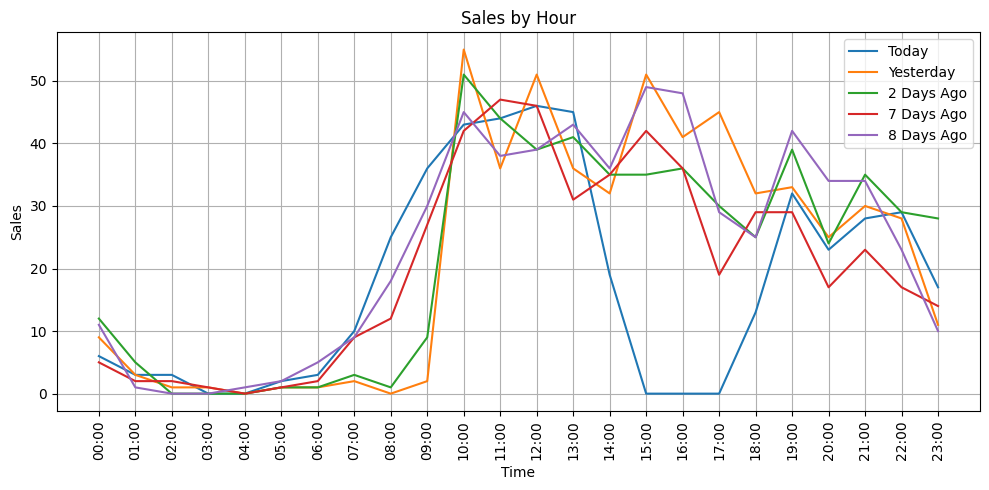

In [9]:
plt.figure(figsize=(10, 5))

plt.plot(df_join['time'], df_join['today'], label='Today')
plt.plot(df_join['time'], df_join['yesterday'], label='Yesterday')
plt.plot(df_join['time'], df_join['2d_ago'], label='2 Days Ago')
plt.plot(df_join['time'], df_join['7d_ago'], label='7 Days Ago')
plt.plot(df_join['time'], df_join['8d_ago'], label='8 Days Ago')

plt.title('Sales by Hour')
plt.xlabel('Time')
plt.ylabel('Sales')

plt.xticks(df_join['time'], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()